In [2]:
#tool-1 reasearch paper reader arxiv
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
#arxivqueryrun takes the query and fetches the research papers.
#arxivapwraper takes additonal queries from the user like to results to be fetched, max char data
#authors, categories such things can be specified with wrapper easily.

api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv, description="Query arxiv papers")
print(arxiv.name)


arxiv


In [3]:
#lets see whether my arxiv tool returns the research papers based on the query or not?
arxiv.invoke("Attention is all you need")

'Published: 2021-05-07\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [4]:
#tool-2 wikipedia reader

wiki_api_wrapper = WikipediaAPIWrapper(doc_content_chars_max=500, top_k_results=2)
wiki = WikipediaQueryRun(api_wrapper=wiki_api_wrapper, description="wikipedia query tool")
print(wiki.name)


wikipedia


In [5]:
#lets see now whether wiki tool fetches the results from the wikipedia or not
wiki.invoke("machine learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [6]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["TAVILY_API_KEY"]  = os.getenv('TAVILY_API_KEY')
os.environ["GROQ_API_KEY"] = os.getenv('GROQ_API_KEY')

In [7]:
#tool 3- tavily for internet search purpose
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()
tavily.invoke("Provide me the current news about physics wallah ipo")

C:\Users\DCQUASTER JACK\AppData\Local\Temp\ipykernel_19120\626080648.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


[{'title': 'Physicswallah IPO subscribed 13%',
  'url': 'https://www.icicidirect.com/ipo/ipo-news/ipo/physicswallah-ipo-subscribed-13percentage/1653562',
  'content': 'Ahead of the IPO, Physicswallah, on 10 November 2025, raised Rs 1,562.84 crore from anchor investors. The board allotted 14,33,80,733 shares at',
  'score': 0.99974686},
 {'title': 'PhysicsWallah IPO Day 2 Highlights: Issue booked 13% - Mint',
  'url': 'https://www.livemint.com/market/ipo/physicswallah-ipo-gmp-physicswallah-ipo-subscription-status-physicswallah-ipo-review-physicswallah-ipo-anchorinvestor-11762920376273.html',
  'content': 'PhysicsWallah IPO Day 2 LIVE: Bhavik Joshi, Business Head, INVasset PMS, said that PhysicsWallah IPO marks a defining moment for India’s edtech sector, symbolizing the transition from digital virality to institutional scale. The company’s evolution—from a single YouTube channel to a multi-format learning ecosystem spanning over 300 offline and hybrid centers—underscores its deep studen

In [8]:
tools = [arxiv, wiki, tavily]

In [9]:
from langchain_groq import ChatGroq

llm = ChatGroq(model = 'qwen/qwen3-32b')
llm.invoke("What is AI ?")

AIMessage(content='<think>\nOkay, the user asked, "What is AI?" Let me start by breaking down the question. They probably want a clear and concise definition of artificial intelligence. First, I should mention that AI refers to machines or software that can perform tasks requiring human-like intelligence. But I need to go beyond just the definition.\n\nMaybe I should list some key areas where AI is applied, like machine learning, natural language processing, computer vision, etc. These are specific techniques or subsets of AI, right? Also, it\'s important to differentiate between narrow AI and artificial general intelligence. Most current AI is narrow, focused on specific tasks, while AGI is still theoretical.\n\nI should explain that AI systems use data to learn and improve over time. For example, machine learning algorithms analyze data to find patterns and make decisions. Neural networks, especially deep learning, are a big part of modern AI. Maybe give examples like recommendation 

In [10]:
#now we need to merge all these tools with the llm
llm_with_tools = llm.bind_tools(tools=tools)
#with tools combined , it can answer from its knowledge + research paper using arxiv + wikipedia using wiki + internet current data using tavily
llm_with_tools.invoke("Hi my name is abhishek, and tell me the current news on AI, and also tell me in short about attention is all you need research paper")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, let\'s tackle the user\'s request. His name is Abhishek, and he wants current news on AI and a short summary of the "Attention is All You Need" paper.\n\nFirst, for the current news on AI, I need to use a search engine that provides up-to-date information. The available tools are arxiv, wikipedia, and tavily_search_results_json. Arxiv is for academic papers, Wikipedia for general info, and Tavily seems to be a search engine for current events. The user specified "current news," so Tavily is the best choice here. I\'ll use the tavily_search_results_json function with a query like "recent developments in AI 2024" to get the latest news.\n\nNext, the "Attention is All You Need" paper. That\'s a well-known research paper, so Wikipedia might have a good summary. Alternatively, arxiv could provide the original paper. But since the user wants a short summary, Wikipedia is more accessible. I\'ll check the wikipedia function w

# Agentic AI WorkFlow using LangGrpah

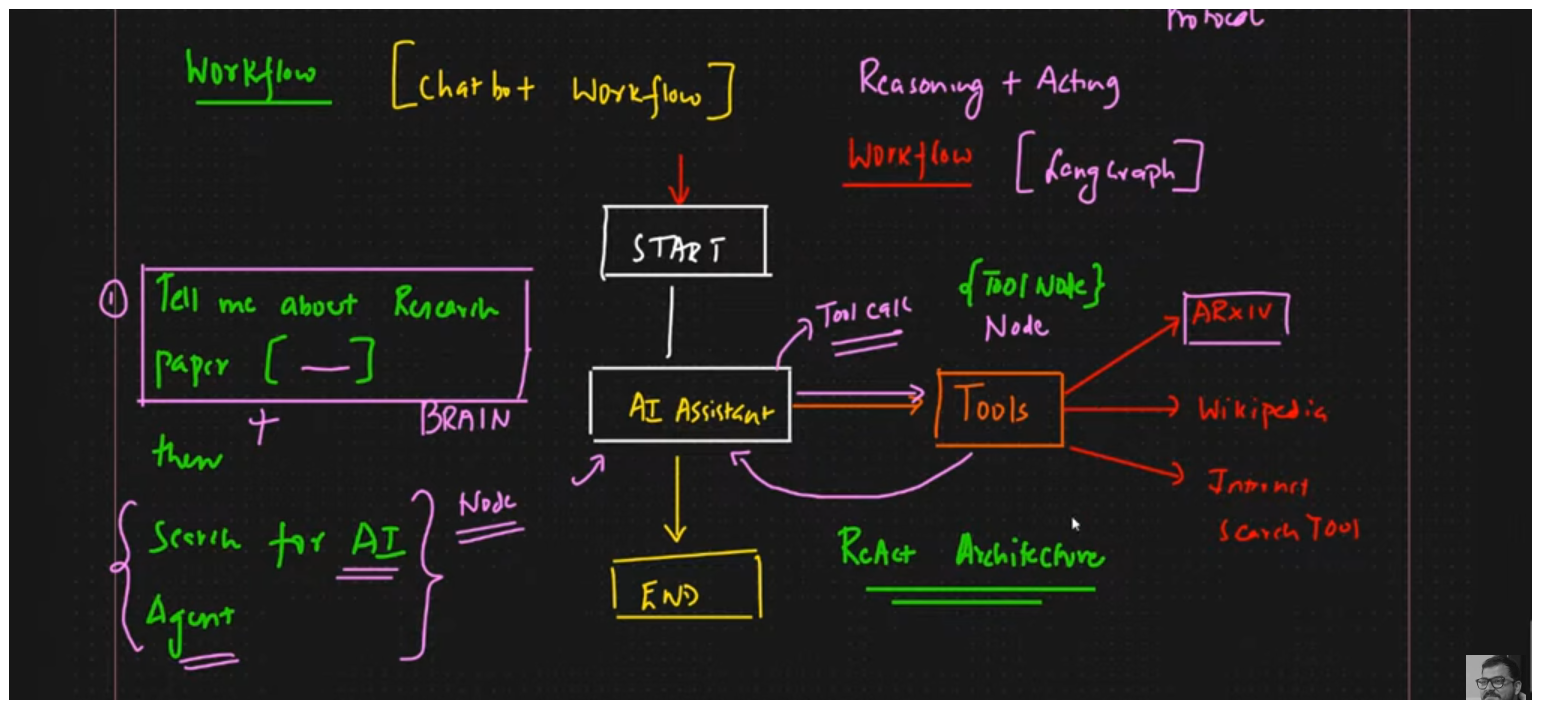

As per above workflow, it should start with START, then Ai asistant which is the main brain here,
then it goes to Tools which decides which tools to call, and then if the all part of the query is answered using each tool required, then END the flow.

In [11]:
#state schema
#for btter type check and code safety , basically for typehints
from typing_extensions import TypedDict
#Anymessage actually means any messages either from human, AI, tools- to make sure llm does not have to
#worry about the source of the message, and can just worry about answering the query regardless of the source.
from langchain_core.messages import AnyMessage #Human message or AI message
#nnotated lets us add custom validations, metadata to type hints
from typing import Annotated #labelling
#following lets us add messages whether user/tool/ai to the conversation
from langgraph.graph.message import add_messages #Reducers in Langgraph

In [12]:
class State(TypedDict):
    messages: list[Annotated[AnyMessage,"messages"]]

In [13]:
#Entire chatbot with langraph

#for displaying images directly in jupyter notebook
from IPython.display import Image, display

#start, end marks entry and exit of workflow, stategraph build the conversation flow graph.
from langgraph.graph import StateGraph, START, END

#a prebuilt tool node to wrap tool functions easily into the workflow graph.
from langgraph.prebuilt import ToolNode

#used to decide which tool node to be called, based on chat state or user input
from langgraph.prebuilt import tools_condition

In [14]:
#Node defintion - AI assistant
def tool_calling_llm(state: State):
    return {"messages":[llm_with_tools.invoke(state['messages'])]}
#here this is written in the form of list, cause State is defined in this format only to contain the conversational flow.
#so what ever it returns it will be appended in the stategraph as add_messages method has been used.

In [15]:
#add nodes
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
#now ai assitant is to call the tools required , for which we will add the nodes
builder.add_node("tools", ToolNode(tools))

In [16]:
#edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", END)

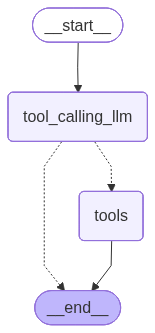

In [17]:
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
messages = graph.invoke({"messages":"1706.03762"})
for m in messages['messages']:
    m.pretty_print()

================================= Tool Message =================================
Name: arxiv

Published: 2023-08-03
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base


In [19]:
messages = graph.invoke({"messages":"Hi, my name is Lalu"})
for m in messages['messages']:
    m.pretty_print()

================================== Ai Message ==================================

Hello Lalu! How can I assist you today?


In [20]:
messages = graph.invoke({"messages":"Hi, my name is Lalu, and please tell me about recent research on quantum computing"})
for m in messages['messages']:
    m.pretty_print()

================================= Tool Message =================================
Name: arxiv

Published: 2025-07-04
Title: Quantum Computing: Vision and Challenges
Authors: Sukhpal Singh Gill, Oktay Cetinkaya, Stefano Marrone, Daniel Claudino, David Haunschild, Leon Schlote, Huaming Wu, Carlo Ottaviani, Xiaoyuan Liu, Sree Pragna Machupalli, Kamalpreet Kaur, Priyansh Arora, Ji Liu, Ahmed Farouk, Houbing Herbert Song, Steve Uhlig, Kotagiri Ramamohanarao
Summary: The recent development of quantum computing, which uses entanglement, superposition, and other quantum fundamental concepts, can 


In [21]:
#here the workflow is to just decide a tool, a single tool and answer the question, and based on the question , it took the last major question about research paper, discarding greeting which comes dierctly from llm

In [22]:
messages = graph.invoke({"messages":"please tell me about recent research on quantum computing and Hi, my name is Lalu."})
for m in messages['messages']:
    m.pretty_print()

================================= Tool Message =================================
Name: arxiv

Published: 2023-02-02
Title: Tierkreis: A Dataflow Framework for Hybrid Quantum-Classical Computing
Authors: Seyon Sivarajah, Lukas Heidemann, Alan Lawrence, Ross Duncan
Summary: We present Tierkreis, a higher-order dataflow graph program representation and runtime designed for compositional, quantum-classical hybrid algorithms. The design of the system is motivated by the remote nature of quantum computers, the need for hybrid algorithms to involve cloud and distributed computing, and the long-


In [23]:
#so the sequence is of no importance, it understood the major question, lets now ask the question from tavily and arxiv
messages = graph.invoke({"messages":"please tell me about recent research on quantum computing and please tell me current news on AI"})
for m in messages['messages']:
    m.pretty_print()

================================= Tool Message =================================
Name: arxiv

Published: 2025-07-04
Title: Quantum Computing: Vision and Challenges
Authors: Sukhpal Singh Gill, Oktay Cetinkaya, Stefano Marrone, Daniel Claudino, David Haunschild, Leon Schlote, Huaming Wu, Carlo Ottaviani, Xiaoyuan Liu, Sree Pragna Machupalli, Kamalpreet Kaur, Priyansh Arora, Ji Liu, Ahmed Farouk, Houbing Herbert Song, Steve Uhlig, Kotagiri Ramamohanarao
Summary: The recent development of quantum computing, which uses entanglement, superposition, and other quantum fundamental concepts, can 
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News | Latest AI News, Analysis & Events", "url": "https://www.artificialintelligence-news.com/", "content": "AI News reports on the latest artificial intelligence news and insights. Explore industry trends from the frontline of AI.", "score": 0.9951325}, {"title": "Year in 

In [24]:
#now we will be changing the workflow a little, where toolnode is going to call the tool_calling_condition again to handle queries which requires answers to be built from multiple sources.
#add nodes
builder2 = StateGraph(State)
builder2.add_node("tool_calling_llm", tool_calling_llm)
#now ai assitant is to call the tools required , for which we will add the nodes
builder2.add_node("tools", ToolNode(tools))
#edges
builder2.add_edge(START, "tool_calling_llm")
builder2.add_conditional_edges("tool_calling_llm", tools_condition)
builder2.add_edge("tools", "tool_calling_llm")

graph2 = builder2.compile()

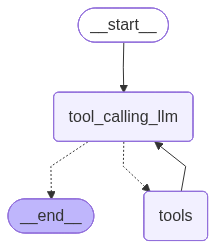

In [25]:
display(Image(graph2.get_graph().draw_mermaid_png()))

In [29]:
#so the sequence is of no importance, it understood the major question, lets now ask the question from tavily and arxiv
messages = graph.invoke({"messages":"please tell me about recent research on quantum computing and please tell me current news on AI"})
for m in messages['messages']:
    m.pretty_print()

================================= Tool Message =================================
Name: arxiv

Published: 2025-07-04
Title: Quantum Computing: Vision and Challenges
Authors: Sukhpal Singh Gill, Oktay Cetinkaya, Stefano Marrone, Daniel Claudino, David Haunschild, Leon Schlote, Huaming Wu, Carlo Ottaviani, Xiaoyuan Liu, Sree Pragna Machupalli, Kamalpreet Kaur, Priyansh Arora, Ji Liu, Ahmed Farouk, Houbing Herbert Song, Steve Uhlig, Kotagiri Ramamohanarao
Summary: The recent development of quantum computing, which uses entanglement, superposition, and other quantum fundamental concepts, can 
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "6 Game-Changing AI Breakthroughs That Defined 2024 | Bernard Marr", "url": "https://bernardmarr.com/6-game-changing-ai-breakthroughs-that-defined-2024/", "content": "2024 will go down as a year in which we saw much groundbreaking progress and many giant leaps forward in the dev

In [ ]:
#here, we asked 2 questions in the same query, first about the research paper, then crrent news result
#both are answered, which means, back to back, the calls were made to tool_calling_llm to handle different part of the quer
#and then each answer is appended as per add_messages.